In [1]:
!pip install torch
!pip install osmnx
!pip install torch_geometric
!pip install pandas numpy osmnx geopandas shapely matplotlib scikit-learn pathlib gymnasium torch torch_geometric torch_sparse torch_scatter

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 965.4/965.4 kB 15.0 MB/s eta 0:00:00


In [3]:
import glob
import warnings
import time
from tqdm import tqdm

import pandas as pd
import numpy as np
import osmnx as ox
import networkx as nx

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from torch_geometric.data import Data
from torch_geometric.nn import GINEConv

from sklearn.model_selection import train_test_split

from torch.nn import Linear, ReLU, Dropout, LayerNorm, GRU

In [5]:
import glob
import warnings
import torch
import pandas as pd
import numpy as np
import os

# Ignore specific runtime warnings
warnings.filterwarnings("ignore", message="invalid value encountered in cast", category=RuntimeWarning)

# Set device
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {DEVICE}")

# Columns to load
temp_cols = [
    'VehId','Trip','Timestamp(ms)',
    'Latitude[deg]','Longitude[deg]',
    'Vehicle Speed[km/h]','MAF[g/sec]',
    'Engine RPM[RPM]','Absolute Load[%]',
    'Speed Limit[km/h]'
]
chunksize = 200_000

# Lists to collect stats and cleaned data
lat_mins, lat_maxs, lon_mins, lon_maxs = [], [], [], []
_cleaned_frames = []

def load_ev_data(path):
    for chunk in pd.read_csv(
        path,
        usecols=temp_cols,
        chunksize=chunksize,
        low_memory=False,
        on_bad_lines='warn'
    ):
        # Force conversion manually
        for col in ['VehId', 'Trip']:
            if col in chunk:
                chunk[col] = pd.to_numeric(chunk[col], errors='coerce').fillna(0).astype('int32')

        for c in temp_cols[2:]:
            if c in chunk:
                num = pd.to_numeric(chunk[c], errors='coerce').fillna(0)
                chunk[c] = num.astype('float32') if c != 'Timestamp(ms)' else num.astype('int64')

        # Drop invalid lat/lon rows
        chunk = chunk[(chunk['Latitude[deg]'] != 0) & (chunk['Longitude[deg]'] != 0)]
        if chunk.empty:
            continue

        lat_mins.append(chunk['Latitude[deg]'].min())
        lat_maxs.append(chunk['Latitude[deg]'].max())
        lon_mins.append(chunk['Longitude[deg]'].min())
        lon_maxs.append(chunk['Longitude[deg]'].max())

        # Sort and store cleaned chunk
        _cleaned_frames.append(chunk.sort_values(['VehId','Trip','Timestamp(ms)']))

# --- Change directory to your actual data folder ---
file_paths = glob.glob(os.path.expanduser('~/Downloads/eVED/*.csv'))
if not file_paths:
    raise FileNotFoundError("No CSV files found in ~/Downloads/eVED/")
for p in file_paths:
    load_ev_data(p)

# Concatenate all cleaned chunks
ev_df = pd.concat(_cleaned_frames, ignore_index=True)
print(f"Loaded EV data: {len(ev_df)} rows")

# Calculate global latitude/longitude min and max
LAT_MIN, LAT_MAX = min(lat_mins), max(lat_maxs)
LNG_MIN, LNG_MAX = min(lon_mins), max(lon_maxs)

# Normalize coordinates function
def normalize_coords(lat, lon):
    nl = (lat - LAT_MIN)/(LAT_MAX - LAT_MIN) if LAT_MAX != LAT_MIN else 0
    ml = (lon - LNG_MIN)/(LNG_MAX - LNG_MIN) if LNG_MAX != LNG_MIN else 0
    return np.clip(nl, 0, 1), np.clip(ml, 0, 1)

Using device: cpu
Loaded EV data: 22436808 rows


In [6]:
center_lat, center_lon = (LAT_MIN+LAT_MAX)/2, (LNG_MIN+LNG_MAX)/2
print("Downloading OSMnx graph…")
G_nx = ox.graph_from_point((center_lat, center_lon), dist=30000, network_type='drive')

node_id_map = {nid:i for i,nid in enumerate(G_nx.nodes())}
idx2osm = {i:nid for nid,i in node_id_map.items()}

# Node features: normalized coords
node_feats = []
for nid, data in G_nx.nodes(data=True):
    nl, ml = normalize_coords(data['y'], data['x'])
    node_feats.append([nl, ml])
x = torch.tensor(node_feats, dtype=torch.float)

# Edge features + index
e_u, e_v, edge_feats = [], [], []
lengths, speeds = [], []
for u, v, data in G_nx.edges(data=True):
    lengths.append(data.get('length', 0.0))
    ms = data.get('maxspeed', 0)
    if isinstance(ms, list): ms = ms[0]
    try:
        speeds.append(float(str(ms).split()[0]))
    except:
        speeds.append(0.0)

max_len = max(lengths) or 1.0
MAX_SP = 130.0

for (u, v), length, speed in zip(G_nx.edges(), lengths, speeds):
    ui, vi = node_id_map[u], node_id_map[v]
    e_u.append(ui); e_v.append(vi)
    nl = length / max_len
    ns = np.clip(speed / MAX_SP, 0, 1)
    edge_feats.append([nl, ns])

edge_index = torch.tensor([e_u, e_v], dtype=torch.long)
edge_attr  = torch.tensor(edge_feats, dtype=torch.float)
graph = Data(x=x, edge_index=edge_index, edge_attr=edge_attr).to(DEVICE)
print(graph)

# Precompute quick lookup from (osm_u,osm_v) → edge_idx
osm_edge_to_idx = {
    (idx2osm[u], idx2osm[v]): i
    for i, (u, v) in enumerate(zip(edge_index[0].tolist(), edge_index[1].tolist()))
}

Data(x=[38073, 2], edge_index=[2, 96402], edge_attr=[96402, 2])


In [7]:
ev_df['node_osm'] = ox.nearest_nodes(
    G_nx,
    X=ev_df['Longitude[deg]'],
    Y=ev_df['Latitude[deg]']
)
ev_df['node_idx'] = ev_df['node_osm'].map(node_id_map)
ev_df.dropna(subset=['node_idx'], inplace=True)
ev_df['node_idx'] = ev_df['node_idx'].astype(int)
ev_df.sort_values(['VehId','Trip','Timestamp(ms)'], inplace=True)

# Compute per-step durations & energy
ev_df['duration_s'] = ev_df.groupby(['VehId','Trip'])['Timestamp(ms)']\
                       .diff().fillna(0) / 1000
ev_df['step_energy'] = ev_df['MAF[g/sec]'] * ev_df['duration_s']

# Collect trips with start, end, true_energy
trips = []
for _, grp in ev_df.groupby(['VehId','Trip']):
    if len(grp) < 2:
        continue
    s = int(grp.iloc[0].node_idx)
    d = int(grp.iloc[-1].node_idx)
    E = grp.step_energy.sum()
    if s != d and E > 0:
        trips.append({'source': s, 'destination': d, 'true_energy': E})

trips_df = pd.DataFrame(trips)
print(f"Processed {len(trips_df)} trips")

Processed 25633 trips


In [8]:
class PathTripDataset(Dataset):
    def __init__(self, trip_df, osm_graph, osm_to_idx, edge_lookup):
        self.trips = trip_df.reset_index(drop=True)
        self.G_nx = osm_graph
        self.idx2osm = idx2osm
        self.edge_lookup = edge_lookup
        self._path_cache = {}

    def __len__(self):
        return len(self.trips)

    def __getitem__(self, i):
        r = self.trips.iloc[i]
        src_idx = int(r.source)
        dst_idx = int(r.destination)
        os_src = self.idx2osm[src_idx]
        os_dst = self.idx2osm[dst_idx]

        # shortest path of osm IDs
        try:
            if (os_src, os_dst) in self._path_cache:
                path_nodes = self._path_cache[(os_src, os_dst)]
            else:
                try:
                    path_nodes = nx.shortest_path(self.G_nx, os_src, os_dst, weight='length')
                except (nx.NetworkXNoPath, nx.NodeNotFound):
                    path_nodes = []
                self._path_cache[(os_src, os_dst)] = path_nodes
        except (nx.NetworkXNoPath, nx.NodeNotFound):
            path_nodes = []

        # map successive node pairs to edge indices
        idxs = []
        for u_osm, v_osm in zip(path_nodes[:-1], path_nodes[1:]):
            ei = self.edge_lookup.get((u_osm, v_osm))
            if ei is not None:
                idxs.append(ei)

        edge_idxs = torch.tensor(idxs, dtype=torch.long)
        energy_log = torch.tensor(np.log1p(r.true_energy), dtype=torch.float32)
        return edge_idxs, energy_log

def collate_paths(batch):
    paths, energies = zip(*batch)
    return list(paths), torch.stack(energies)

# Splits
train_df, val_df = train_test_split(trips_df, test_size=0.15, random_state=42)
train_ds = PathTripDataset(train_df, G_nx, node_id_map, osm_edge_to_idx)
val_ds   = PathTripDataset(val_df,   G_nx, node_id_map, osm_edge_to_idx)

train_loader = DataLoader(
    train_ds, batch_size=16, shuffle=True, collate_fn=collate_paths
)
val_loader = DataLoader(
    val_ds, batch_size=32, shuffle=False, collate_fn=collate_paths
)

In [9]:
class GNNPathEnergyPredictor(nn.Module):
    def __init__(self, node_dim, edge_dim, hid=128, rnn_hid=128, nlayers=4, drop=0.3):
        super().__init__()
        self.node_emb = Linear(node_dim, hid)
        self.edge_emb = Linear(edge_dim, hid)

        self.convs = nn.ModuleList()
        self.norms = nn.ModuleList()
        for _ in range(nlayers):
            mlp = nn.Sequential(Linear(hid, hid), ReLU(), Linear(hid, hid))
            self.convs.append(GINEConv(mlp, edge_dim=hid))
            self.norms.append(LayerNorm(hid))

        self.rnn = GRU(input_size=3*hid, hidden_size=rnn_hid, batch_first=True)
        self.decoder = nn.Sequential(
            Linear(rnn_hid, hid),
            ReLU(),
            Dropout(drop),
            Linear(hid, 1)
        )

    def forward(self, graph, path_list):
        x = self.node_emb(graph.x)
        ea = self.edge_emb(graph.edge_attr)
        # GINE layers
        for conv, norm in zip(self.convs, self.norms):
            res = x
            x = conv(x, graph.edge_index, ea)
            x = norm(x)
            x = F.relu(x) + res
        emb = x

        # build per-path sequences of [src_emb | edge_emb | dst_emb]
        seqs = []
        for eidx in path_list:
            src_nodes = graph.edge_index[0, eidx]
            dst_nodes = graph.edge_index[1, eidx]
            seq = torch.cat([emb[src_nodes], ea[eidx], emb[dst_nodes]], dim=1)
            seqs.append(seq)

        # pack & GRU
        lengths = [s.size(0) for s in seqs]
        padded = nn.utils.rnn.pad_sequence(seqs, batch_first=True)
        packed = nn.utils.rnn.pack_padded_sequence(
            padded, lengths, batch_first=True, enforce_sorted=False
        )
        _, h = self.rnn(packed)
        out = self.decoder(h.squeeze(0)).squeeze(1)
        return out

In [10]:
model = GNNPathEnergyPredictor(
    node_dim=graph.x.shape[1],
    edge_dim=graph.edge_attr.shape[1]
).to(DEVICE)
opt = torch.optim.Adam(model.parameters(), lr=5e-4)
loss_fn = nn.MSELoss()

best_val = float('inf')
for epoch in range(1, 31):
    t0 = time.time()
    model.train()
    train_loss = 0
    for paths, energies in tqdm(train_loader, desc=f"Epoch {epoch} [train]"):
        opt.zero_grad()
        preds = model(graph, [p.to(DEVICE) for p in paths])
        loss = loss_fn(preds, energies.to(DEVICE))
        loss.backward()
        opt.step()
        train_loss += loss.item()
    train_loss /= len(train_loader)

    model.eval()
    val_loss = 0
    with torch.no_grad():
        for paths, energies in tqdm(val_loader, desc=f"Epoch {epoch} [val]"):
            preds = model(graph, [p.to(DEVICE) for p in paths])
            val_loss += loss_fn(preds, energies.to(DEVICE)).item()
    val_loss /= len(val_loader)

    print(f"Epoch {epoch:02d} | train {train_loss:.4f} | val {val_loss:.4f} | {time.time()-t0:.1f}s")
    if val_loss < best_val:
        best_val = val_loss
        torch.save(model.state_dict(), './best_path_energy_predictor.pth')
        print("  🚀 Saved improved model")

print("Training complete. Best val loss:", best_val)

Epoch 1 [val]: 100%|██████████████████████████| 121/121 [00:24<00:00,  5.02it/s]


Epoch 01 | train 2.1215 | val 0.6921 | 634.5s
  🚀 Saved improved model


Epoch 2 [val]: 100%|██████████████████████████| 121/121 [00:15<00:00,  7.84it/s]


Epoch 02 | train 1.3090 | val 0.7204 | 600.5s


Epoch 3 [val]: 100%|██████████████████████████| 121/121 [00:15<00:00,  7.82it/s]


Epoch 03 | train 1.2702 | val 0.6450 | 600.5s
  🚀 Saved improved model


Epoch 4 [val]: 100%|██████████████████████████| 121/121 [00:15<00:00,  7.63it/s]


Epoch 04 | train 1.2105 | val 0.6716 | 594.8s


Epoch 5 [val]: 100%|██████████████████████████| 121/121 [00:14<00:00,  8.10it/s]


Epoch 05 | train 1.1584 | val 0.6152 | 588.1s
  🚀 Saved improved model


Epoch 6 [val]: 100%|██████████████████████████| 121/121 [00:14<00:00,  8.17it/s]


Epoch 06 | train 1.1075 | val 0.6629 | 579.2s


Epoch 7 [val]: 100%|██████████████████████████| 121/121 [00:15<00:00,  7.96it/s]


Epoch 07 | train 1.0605 | val 0.6138 | 578.1s
  🚀 Saved improved model


Epoch 8 [val]: 100%|██████████████████████████| 121/121 [00:14<00:00,  8.11it/s]


Epoch 08 | train 1.0356 | val 0.5989 | 581.5s
  🚀 Saved improved model


Epoch 9 [val]: 100%|██████████████████████████| 121/121 [00:14<00:00,  8.14it/s]


Epoch 09 | train 1.0134 | val 0.5789 | 569.0s
  🚀 Saved improved model


Epoch 10 [val]: 100%|█████████████████████████| 121/121 [00:36<00:00,  3.28it/s]


Epoch 10 | train 0.9725 | val 0.5471 | 980.2s
  🚀 Saved improved model


Epoch 11 [val]: 100%|█████████████████████████| 121/121 [00:49<00:00,  2.46it/s]


Epoch 11 | train 0.9688 | val 0.6128 | 1141.2s


Epoch 12 [val]: 100%|█████████████████████████| 121/121 [00:14<00:00,  8.31it/s]


Epoch 12 | train 0.9307 | val 0.5495 | 1224.1s


Epoch 13 [val]: 100%|█████████████████████████| 121/121 [00:14<00:00,  8.19it/s]


Epoch 13 | train 0.8983 | val 0.5272 | 1183.1s
  🚀 Saved improved model


Epoch 14 [val]: 100%|█████████████████████████| 121/121 [00:14<00:00,  8.24it/s]


Epoch 14 | train 0.8776 | val 0.5316 | 1791.8s


Epoch 15 [val]: 100%|█████████████████████████| 121/121 [00:14<00:00,  8.27it/s]


Epoch 15 | train 0.8591 | val 0.6563 | 2052.3s


Epoch 16 [val]: 100%|█████████████████████████| 121/121 [00:14<00:00,  8.27it/s]


Epoch 16 | train 0.8410 | val 0.5102 | 938.5s
  🚀 Saved improved model


Epoch 17 [val]: 100%|█████████████████████████| 121/121 [00:15<00:00,  7.86it/s]


Epoch 17 | train 0.8192 | val 0.5123 | 648.2s


Epoch 18 [val]: 100%|█████████████████████████| 121/121 [00:14<00:00,  8.14it/s]


Epoch 18 | train 0.7913 | val 0.7404 | 1247.9s


Epoch 19 [val]: 100%|█████████████████████████| 121/121 [00:14<00:00,  8.15it/s]


Epoch 19 | train 0.7774 | val 0.5076 | 1107.6s
  🚀 Saved improved model


Epoch 20 [val]: 100%|█████████████████████████| 121/121 [00:16<00:00,  7.23it/s]


Epoch 20 | train 0.7511 | val 0.5063 | 633.8s
  🚀 Saved improved model


Epoch 21 [val]: 100%|█████████████████████████| 121/121 [00:14<00:00,  8.20it/s]


Epoch 21 | train 0.7397 | val 0.5179 | 860.1s


Epoch 22 [val]: 100%|█████████████████████████| 121/121 [00:14<00:00,  8.10it/s]


Epoch 22 | train 0.7362 | val 0.5110 | 1464.0s


Epoch 23 [val]: 100%|█████████████████████████| 121/121 [00:14<00:00,  8.13it/s]


Epoch 23 | train 0.7148 | val 0.4994 | 575.5s
  🚀 Saved improved model


Epoch 24 [val]: 100%|█████████████████████████| 121/121 [00:14<00:00,  8.10it/s]


Epoch 24 | train 0.6884 | val 0.4903 | 763.8s
  🚀 Saved improved model


Epoch 25 [val]: 100%|█████████████████████████| 121/121 [00:15<00:00,  7.62it/s]


Epoch 25 | train 0.6761 | val 0.5120 | 577.5s


Epoch 26 [val]: 100%|█████████████████████████| 121/121 [00:14<00:00,  8.15it/s]


Epoch 26 | train 0.6572 | val 0.5007 | 579.8s


Epoch 27 [val]: 100%|█████████████████████████| 121/121 [00:14<00:00,  8.10it/s]


Epoch 27 | train 0.6513 | val 0.5009 | 569.7s


Epoch 28 [val]: 100%|█████████████████████████| 121/121 [00:14<00:00,  8.15it/s]


Epoch 28 | train 0.6226 | val 0.4901 | 567.9s
  🚀 Saved improved model


Epoch 29 [val]: 100%|█████████████████████████| 121/121 [00:14<00:00,  8.20it/s]


Epoch 29 | train 0.6214 | val 0.4901 | 564.2s


Epoch 30 [val]: 100%|█████████████████████████| 121/121 [00:14<00:00,  8.18it/s]

Epoch 30 | train 0.6009 | val 0.5126 | 566.1s
Training complete. Best val loss: 0.4901300139171033


In [14]:
save_path = os.path.expanduser('~/Downloads/best_path_energy_predictor.pth')
torch.save(model.state_dict(), save_path)
print(f"✅ Model saved to {save_path}")

✅ Model saved to /Users/vg/Downloads/best_path_energy_predictor.pth


Generating visualizations...

1. Visualizing paths on map...
Map saved to 'path_visualization_map.html'

2. Creating prediction scatter plot...
Could not calculate metrics: got an unexpected keyword argument 'squared'
Scatter plot saved as 'energy_prediction_scatter.png'

3. Visualizing edge features...
Edge feature distribution saved as 'edge_feature_distribution.png'

4. Creating energy consumption heatmap...
Energy heatmap saved to 'energy_consumption_heatmap.html'

5. Plotting path length vs. energy...
Could not calculate regression: module 'pandas' has no attribute 'np'
Path length vs. energy plot saved as 'path_length_vs_energy.png'

6. Creating network visualization...


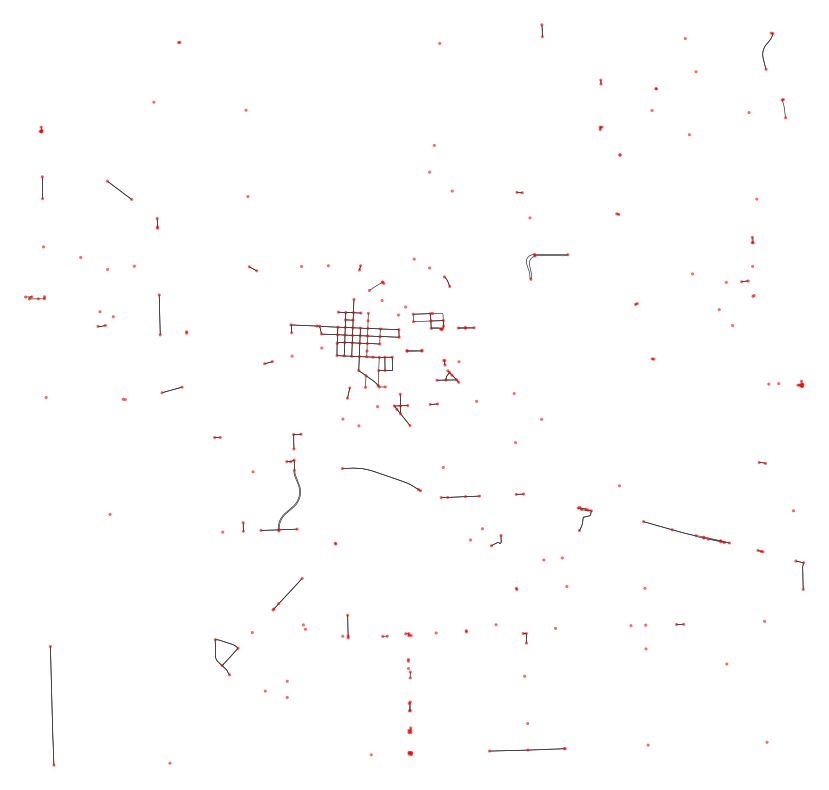

Network visualization saved as 'network_energy_visualization.png'

Visualizations completed! Check for generated files.


In [18]:
import matplotlib.pyplot as plt
import folium
from folium.plugins import HeatMap
import seaborn as sns
import torch
import math
import osmnx as ox
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Define a fallback for numpy's expm1 function
def expm1(x):
    return math.exp(x) - 1 if isinstance(x, (int, float)) else [math.exp(val) - 1 for val in x]

# 1. Path Visualization on a Map
def visualize_paths_on_map(G_nx, idx2osm, model, graph, val_loader, num_samples=5):
    # Load the best model
    try:
        model.load_state_dict(torch.load('./best_path_energy_predictor.pth'))
    except Exception as e:
        print(f"Could not load saved model: {e}. Using current model state.")
    
    model.eval()
    
    # Sample paths from validation set
    samples = []
    with torch.no_grad():
        for paths, energies in val_loader:
            for i in range(min(len(paths), num_samples)):
                path_edges = paths[i]
                true_energy = math.exp(energies[i].item()) - 1  # expm1
                
                # Get the prediction
                pred = model(graph, [path_edges.to(DEVICE)])
                pred_energy = math.exp(pred.cpu().item()) - 1  # expm1
                
                # Extract the nodes in the path
                src_nodes = graph.edge_index[0, path_edges].cpu().tolist()
                dst_nodes = graph.edge_index[1, path_edges].cpu().tolist()
                
                # Convert to OSM node IDs
                path_osm_nodes = []
                if len(src_nodes) > 0:
                    path_osm_nodes = [idx2osm[src_nodes[0]]]
                    for node in dst_nodes:
                        path_osm_nodes.append(idx2osm[node])
                
                samples.append({
                    'path_osm_nodes': path_osm_nodes,
                    'true_energy': true_energy,
                    'pred_energy': pred_energy
                })
                
                if len(samples) >= num_samples:
                    break
            if len(samples) >= num_samples:
                break
    
    # Create a Folium map centered on the first path
    if samples and samples[0]['path_osm_nodes']:
        first_node = samples[0]['path_osm_nodes'][0]
        node_data = G_nx.nodes[first_node]
        center_lat, center_lon = node_data['y'], node_data['x']
    else:
        # Fallback to graph center
        center_lat, center_lon = (LAT_MIN + LAT_MAX) / 2, (LNG_MIN + LNG_MAX) / 2
    
    m = folium.Map(location=[center_lat, center_lon], zoom_start=12)
    
    # Colors for different paths
    colors = ['blue', 'red', 'green', 'purple', 'orange']
    
    # Add paths to the map
    for i, sample in enumerate(samples):
        if not sample['path_osm_nodes'] or len(sample['path_osm_nodes']) < 2:
            continue
            
        color = colors[i % len(colors)]
        
        # Extract path coordinates
        path_coords = []
        for node_id in sample['path_osm_nodes']:
            if node_id in G_nx.nodes():
                node_data = G_nx.nodes[node_id]
                path_coords.append((node_data['y'], node_data['x']))
        
        if path_coords:
            # Add the path as a polyline
            folium.PolyLine(
                path_coords,
                color=color,
                weight=4,
                opacity=0.8,
                tooltip=f"Path {i+1}: True={sample['true_energy']:.2f}, Pred={sample['pred_energy']:.2f}"
            ).add_to(m)
            
            # Add markers for start and end points
            folium.Marker(
                path_coords[0],
                icon=folium.Icon(color=color, icon='play', prefix='fa'),
                tooltip=f"Start of Path {i+1}"
            ).add_to(m)
            
            folium.Marker(
                path_coords[-1],
                icon=folium.Icon(color=color, icon='stop', prefix='fa'),
                tooltip=f"End of Path {i+1}"
            ).add_to(m)
    
    # Save the map to an HTML file
    m.save('path_visualization_map.html')
    print("Map saved to 'path_visualization_map.html'")
    return m

# 2. Predicted vs. Actual Energy Consumption
def plot_prediction_scatter(model, graph, val_loader):
    try:
        model.load_state_dict(torch.load('./best_path_energy_predictor.pth'))
    except Exception as e:
        print(f"Could not load saved model: {e}. Using current model state.")
    
    model.eval()
    
    true_energies = []
    pred_energies = []
    
    with torch.no_grad():
        for paths, energies in val_loader:
            preds = model(graph, [p.to(DEVICE) for p in paths])
            
            # Convert log values back to original scale
            for i in range(len(energies)):
                true_e = math.exp(energies[i].item()) - 1  # expm1
                pred_e = math.exp(preds[i].item()) - 1  # expm1
                true_energies.append(true_e)
                pred_energies.append(pred_e)
    
    # Create scatter plot
    plt.figure(figsize=(10, 8))
    plt.scatter(true_energies, pred_energies, alpha=0.6)
    
    # Add perfect prediction line
    max_val = max(max(true_energies), max(pred_energies))
    min_val = min(min(true_energies), min(pred_energies))
    plt.plot([min_val, max_val], [min_val, max_val], 'r--')
    
    plt.xlabel('True Energy Consumption')
    plt.ylabel('Predicted Energy Consumption')
    plt.title('Predicted vs. Actual Energy Consumption')
    
    # Calculate metrics
    try:
        mae = mean_absolute_error(true_energies, pred_energies)
        rmse = mean_squared_error(true_energies, pred_energies, squared=False)
        r2 = r2_score(true_energies, pred_energies)
        plt.figtext(0.15, 0.85, f'MAE: {mae:.2f}\nRMSE: {rmse:.2f}\nR²: {r2:.2f}')
    except Exception as e:
        print(f"Could not calculate metrics: {e}")
    
    plt.tight_layout()
    plt.savefig('energy_prediction_scatter.png', dpi=300)
    plt.close()
    print("Scatter plot saved as 'energy_prediction_scatter.png'")
    
    return true_energies, pred_energies

# 3. Edge Feature Importance Visualization
def visualize_edge_features(G_nx, graph, model):
    # Get edge attributes from the graph
    edge_features = graph.edge_attr.cpu().tolist()
    
    # We have two edge features: normalized length and normalized speed
    lengths = [feat[0] for feat in edge_features]
    speeds = [feat[1] for feat in edge_features]
    
    # Create a scatter plot of edge features
    plt.figure(figsize=(10, 8))
    plt.scatter(lengths, speeds, alpha=0.5)
    plt.xlabel('Normalized Road Length')
    plt.ylabel('Normalized Speed Limit')
    plt.title('Edge Feature Distribution')
    
    # Add density contours if seaborn is working
    try:
        sns.kdeplot(x=lengths, y=speeds, levels=5, color='k', linewidths=1)
    except:
        print("Could not generate contour plot with seaborn.")
    
    plt.tight_layout()
    plt.savefig('edge_feature_distribution.png', dpi=300)
    plt.close()
    print("Edge feature distribution saved as 'edge_feature_distribution.png'")

# 4. Create a heatmap of energy consumption
def create_energy_heatmap(G_nx, idx2osm, val_loader, trips_df):
    # Extract node positions
    node_positions = {}
    for node_id, data in G_nx.nodes(data=True):
        node_positions[node_id] = (data['y'], data['x'])
    
    # Get energy values per node from trip data
    node_energy = {}
    for _, row in trips_df.iterrows():
        src_idx = int(row.source)
        dst_idx = int(row.destination)
        src_osm = idx2osm[src_idx]
        dst_osm = idx2osm[dst_idx]
        
        # Split energy evenly between start and end nodes for simplicity
        energy = row.true_energy / 2
        
        if src_osm in node_positions:
            node_energy[src_osm] = node_energy.get(src_osm, 0) + energy
        if dst_osm in node_positions:
            node_energy[dst_osm] = node_energy.get(dst_osm, 0) + energy
    
    # Create heatmap data
    heat_data = []
    for node_id, energy in node_energy.items():
        if node_id in node_positions:
            lat, lon = node_positions[node_id]
            heat_data.append([lat, lon, min(energy, 10000)])  # Cap values to prevent outliers
    
    # Create a Folium map
    center_lat, center_lon = (LAT_MIN + LAT_MAX) / 2, (LNG_MIN + LNG_MAX) / 2
    m = folium.Map(location=[center_lat, center_lon], zoom_start=12)
    
    # Add the heatmap layer
    HeatMap(heat_data, radius=15, blur=10).add_to(m)
    
    # Save the map
    m.save('energy_consumption_heatmap.html')
    print("Energy heatmap saved to 'energy_consumption_heatmap.html'")
    return m

# 5. Path length vs. energy consumption
def plot_path_length_vs_energy(G_nx, idx2osm, trips_df):
    path_lengths = []
    energies = []
    
    for _, row in trips_df.iterrows():
        src_idx = int(row.source)
        dst_idx = int(row.destination)
        src_osm = idx2osm[src_idx]
        dst_osm = idx2osm[dst_idx]
        
        try:
            path = nx.shortest_path(G_nx, src_osm, dst_osm, weight='length')
            # Calculate path length
            path_length = 0
            for u, v in zip(path[:-1], path[1:]):
                # Get edge data between u and v
                if v in G_nx[u]:
                    edge_data = G_nx[u][v][0]  # Get the first (or only) edge between u and v
                    path_length += edge_data.get('length', 0)
            
            path_lengths.append(path_length)
            energies.append(row.true_energy)
        except (nx.NetworkXNoPath, nx.NodeNotFound):
            continue
    
    # Create scatter plot
    plt.figure(figsize=(10, 8))
    plt.scatter(path_lengths, energies, alpha=0.5)
    
    # Add regression line if we have data points
    if path_lengths:
        try:
            df = pd.DataFrame({'x': path_lengths, 'y': energies})
            if len(df) > 1:  # Need at least 2 points for correlation
                # Calculate correlation
                corr = df['x'].corr(df['y'])
                plt.figtext(0.15, 0.85, f'Correlation: {corr:.2f}')
                
                # Simple linear regression
                coefficients = pd.np.polyfit(df['x'], df['y'], 1)
                polynomial = pd.np.poly1d(coefficients)
                x_sorted = sorted(path_lengths)
                plt.plot(x_sorted, [polynomial(x) for x in x_sorted], "r--", linewidth=2)
        except Exception as e:
            print(f"Could not calculate regression: {e}")
    
    plt.xlabel('Path Length (meters)')
    plt.ylabel('Energy Consumption')
    plt.title('Path Length vs. Energy Consumption')
    plt.tight_layout()
    plt.savefig('path_length_vs_energy.png', dpi=300)
    plt.close()
    print("Path length vs. energy plot saved as 'path_length_vs_energy.png'")
    
    return path_lengths, energies

# 6. Basic network visualization with node sizes reflecting energy consumption
def visualize_network_with_energy(G_nx, idx2osm, trips_df):
    # First, collect energy per node
    node_energy = {}
    
    # Process trip data
    for _, row in trips_df.iterrows():
        src_idx = int(row.source)
        dst_idx = int(row.destination)
        src_osm = idx2osm[src_idx] 
        dst_osm = idx2osm[dst_idx]
        
        # Split energy evenly between start and end for simplicity
        energy = row.true_energy / 2
        
        node_energy[src_osm] = node_energy.get(src_osm, 0) + energy
        node_energy[dst_osm] = node_energy.get(dst_osm, 0) + energy
    
    # Calculate node sizes based on energy usage
    node_sizes = {}
    if node_energy:
        max_energy = max(node_energy.values()) or 1
        for node, energy in node_energy.items():
            # Scale node sizes between 5 and 50
            node_sizes[node] = 5 + (energy / max_energy) * 45
    
    # Make a copy of the graph for visualization
    G_vis = G_nx.copy()
    
    # Set node sizes
    nx.set_node_attributes(G_vis, {node: {'size': node_sizes.get(node, 5)} 
                             for node in G_vis.nodes()})
    
    # Plot with OSMNX
    try:
        fig, ax = plt.subplots(figsize=(12, 10))
        node_size = [G_vis.nodes[node].get('size', 5) for node in G_vis.nodes()]
        
        # Create a subgraph with fewer nodes for visibility
        if len(G_vis) > 1000:
            # Keep only the nodes with significant energy
            significant_nodes = [node for node, energy in node_energy.items() 
                                if energy > (sum(node_energy.values()) / len(node_energy)) * 0.5]
            if len(significant_nodes) > 5:  # Make sure we have enough nodes
                G_vis = G_nx.subgraph(significant_nodes).copy()
                node_size = [G_vis.nodes[node].get('size', 5) for node in G_vis.nodes()]
        
        # Plot with OSMnx's plot function
        ox.plot_graph(
            G_vis, 
            ax=ax,
            node_size=node_size,
            node_color='r',
            edge_color='#333333',
            edge_linewidth=0.5,
            node_alpha=0.6
        )
        
        plt.title('Road Network with Node Sizes Representing Energy Consumption')
        plt.tight_layout()
        plt.savefig('network_energy_visualization.png', dpi=300)
        plt.close()
        print("Network visualization saved as 'network_energy_visualization.png'")
    except Exception as e:
        print(f"Could not create network visualization: {e}")

# Run all visualizations
def run_all_visualizations():
    print("Generating visualizations...")
    # Load the model
    model = GNNPathEnergyPredictor(
        node_dim=graph.x.shape[1],
        edge_dim=graph.edge_attr.shape[1]
    ).to(DEVICE)
    
    result_data = {}
    
    # Run each visualization in try-except blocks
    print("\n1. Visualizing paths on map...")
    try:
        vis_map = visualize_paths_on_map(G_nx, idx2osm, model, graph, val_loader)
    except Exception as e:
        print(f"Error in path visualization: {e}")
    
    print("\n2. Creating prediction scatter plot...")
    try:
        true_e, pred_e = plot_prediction_scatter(model, graph, val_loader)
        result_data["true_vs_pred"] = (true_e, pred_e)
    except Exception as e:
        print(f"Error in prediction scatter plot: {e}")
    
    print("\n3. Visualizing edge features...")
    try:
        visualize_edge_features(G_nx, graph, model)
    except Exception as e:
        print(f"Error in edge feature visualization: {e}")
    
    print("\n4. Creating energy consumption heatmap...")
    try:
        heat_map = create_energy_heatmap(G_nx, idx2osm, val_loader, trips_df)
    except Exception as e:
        print(f"Error in energy heatmap creation: {e}")
    
    print("\n5. Plotting path length vs. energy...")
    try:
        path_lengths, path_energies = plot_path_length_vs_energy(G_nx, idx2osm, trips_df)
        result_data["path_vs_energy"] = (path_lengths, path_energies)
    except Exception as e:
        print(f"Error in path length vs energy plot: {e}")
    
    print("\n6. Creating network visualization...")
    try:
        visualize_network_with_energy(G_nx, idx2osm, trips_df)
    except Exception as e:
        print(f"Error in network visualization: {e}")
    
    print("\nVisualizations completed! Check for generated files.")
    
    return result_data

# Call the main function to generate all visualizations
if __name__ == "__main__":
    run_all_visualizations()